# 2021-09-17 Sparsity, solvers, and nonlinear intro

## Last time

* Advection and boundary layers
* The (cell) Péclet number and oscillations

## Today
* Effective use of sparse/structured matrices
* Intro to rootfinding and Newton's method

In [1]:
using Plots
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

fdstencil (generic function with 1 method)

# Advection-diffusion with conservative FD

$$(- \kappa u_x + wu)_x = f$$

In [3]:
function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Experiments, The [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
(- \kappa u_x + wu)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

minimum(diff(x)) = 0.0512820512820511


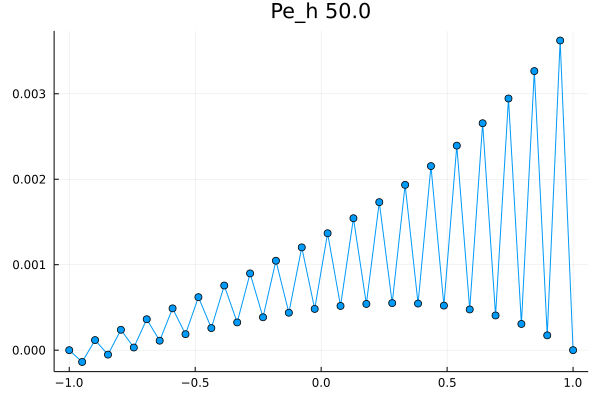

In [7]:
n = 40; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="Pe_h $(wind*h/kappa)")

# Upwinded discretization

Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on my value.

In [12]:
function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [.75 .25] : [0 1])  # <--- was [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [.75 .25] : [0 1])  # <--- was [.5 .5]
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Try it for robustness

minimum(diff(x)) = 0.0512820512820511


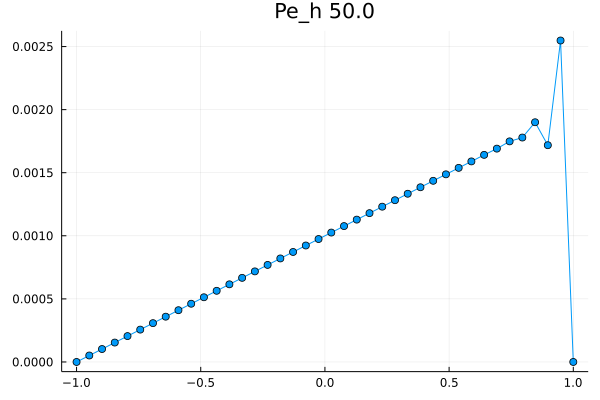

In [14]:
n = 40; h = 2/n
kappa = 1
wind = 1000
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="Pe_h $(wind*h/kappa)")

### What is the order of accuracy of this upwind discretization?

# How expensive is `\`?

In [29]:

x, L, rhs = advdiff_upwind(5000, x -> kappa, wind, one)
@timev L \ rhs;

  1.670357 seconds (6 allocations: 190.792 MiB)
elapsed time (ns): 1670356501
bytes allocated:   200060272
pool allocs:       3
malloc() calls:    3


In [25]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    @elapsed L \ rhs
end
ns = (1:6) * 1000
times = elapsed_solve.(ns)

6-element Vector{Float64}:
 0.012454447
 0.083467243
 0.334782038
 0.534024244
 1.20161831
 1.406723185

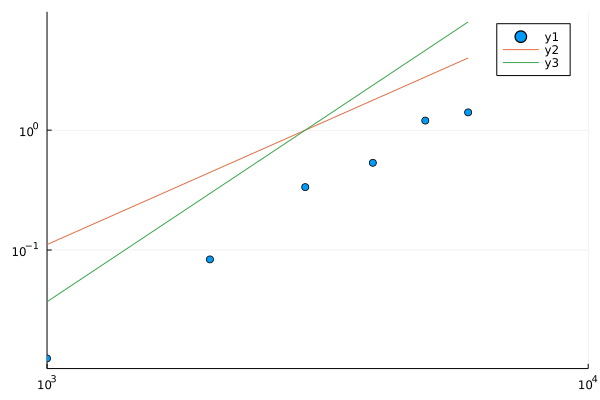

In [26]:
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!(ns, [(ns/3000).^2, (ns/3000).^3], xrange=(1e3, 1e4))

## How long would $n=10000$ take to solve?

## How much memory would $n=10000$ take?

# Sparsity

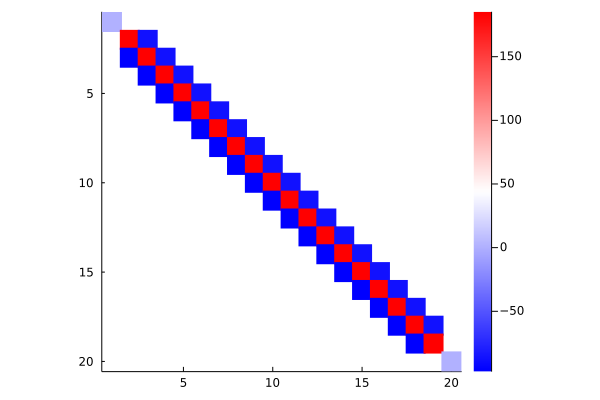

In [39]:
x, L, rhs = advdiff_upwind(20, one, 1, one)
spy(L, marker=(:square, 10), c=:bwr)

In [40]:
using SparseArrays
sparse(L)

20×20 SparseMatrixCSC{Float64, Int64} with 54 stored entries:
⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆

# How does solving with the sparse matrix scale?

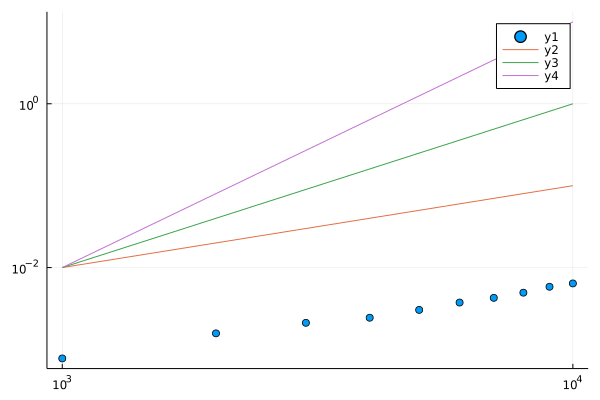

In [41]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    L = sparse(L)
    @elapsed L \ x
end
ns = (1:10) * 1000
times = elapsed_solve.(ns)
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!([n -> 1e-2*n/1000, n -> 1e-2*(n/1000)^2, n -> 1e-2*(n/1000)^3])

## How much memory is needed?

# [SparseArrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/) Compressed Sparse Column (CSC)



In [30]:
# starting with a dense matrix
A = sparse([1 0 0 -2; 0 3.14 0 .4; 5.1 0 0 .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [38]:
@show A.colptr
@show A.rowval
A.nzval

A.colptr = [1, 3, 4, 4, 7]
A.rowval = [1, 3, 2, 1, 2, 3]


6-element Vector{Float64}:
  1.0
  5.1
  3.14
 -2.0
  0.4
  0.06

* CSC (or, more commonly outside Matlab/Julia, row-based CSR) are good for matrix operations (multiplication, solve), but sometimes inconvenient to assemble.

# Matrix assembly using COO format

In [39]:
A

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [48]:
sparse([1, 1, 2, 2, 3, 3, 1],
       [1, 4, 2, 4, 1, 4, 1],
       [1, -2, 3.14, .4, 5.1, .06, 10])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 11.0   ⋅     ⋅   -2.0
   ⋅   3.14   ⋅    0.4
  5.1   ⋅     ⋅    0.06

# Upwind advection-diffusion solver using COO

In [42]:
function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

advdiff_sparse (generic function with 1 method)

# Assembly cost

minimum(diff(x)) = 0.005012531328320691


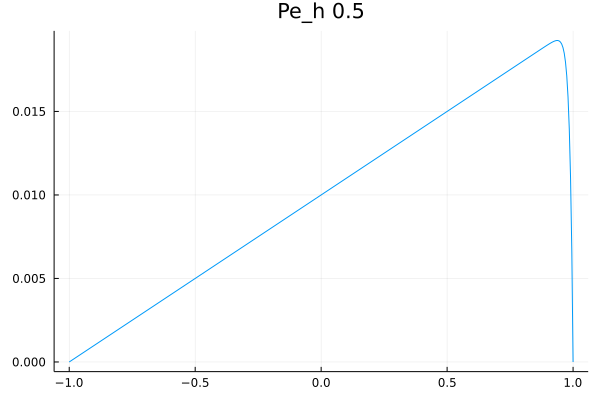

In [43]:
n = 400; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_sparse(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, title="Pe_h $(wind*h/kappa)")

In [44]:
n = 10000
@time advdiff_upwind(n, one, 1, one);
@time advdiff_sparse(n, one, 1, one);

  0.543603 seconds (708.34 k allocations: 803.497 MiB, 19.04% gc time)
  0.195921 seconds (698.92 k allocations: 44.198 MiB, 35.39% gc time)


In [47]:
A = spzeros(5, 5)
A[1,1] = 3
A

5×5 SparseMatrixCSC{Float64, Int64} with 1 stored entry:
 3.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 